In [1]:
import torch
from torchvision import datasets, transforms

In [2]:
import os

from torchvision.utils import make_grid
import torchvision.utils as utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import torch.nn as nn

In [3]:
image_size =64
batch_size = 128


In [4]:
dataset = datasets.CIFAR10(root="./dataset/CIFAR10data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

Files already downloaded and verified


In [5]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [6]:
device = get_default_device()
device

device(type='cpu')

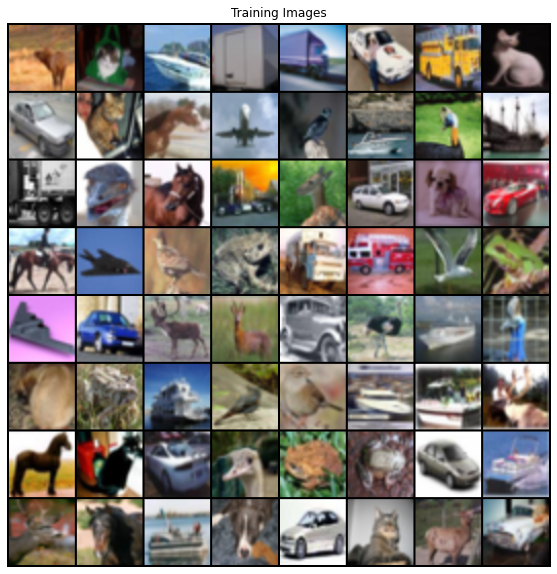

In [7]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [8]:
# train_dl = DeviceDataLoader(dataloaders['train'], device)

In [9]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4,stride=2,padding=1),
#     nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4,stride=2,padding=1),
    nn.BatchNorm2d(128,momentum=0.9),
    nn.LeakyReLU(0.2, inplace=True),
#     # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4,stride=2,padding=1),
    nn.BatchNorm2d(256,momentum=0.9),
    nn.LeakyReLU(0.2, inplace=True),
#     # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4,stride=2,padding=1),
    nn.BatchNorm2d(512,momentum=0.9),
    nn.LeakyReLU(0.2, inplace=True),
#     out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
# #     out:  1 x 1 x 1
    nn.Flatten(),
# #     out: 2304
    
    nn.Sigmoid()
)

In [10]:
# getting op as 64* 31* 31 for k=5
# getting op as 64* 32* 32 for k=4


In [11]:
# for images, labels in train_loader:
#     print('images.shape:', images.shape)
#     inputs = images.reshape(-1, 784)
#     print('inputs.shape:', inputs.shape)
#     break
    
for images, labels in dataloader:
    print('images.shape:', images.shape)
    outputs = discriminator(images)
    print('output.shape:', outputs.shape)
    break

images.shape: torch.Size([128, 3, 64, 64])
output.shape: torch.Size([128, 1])


In [12]:
latent_size = 100

In [13]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512,momentum=0.9),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256,momentum=0.9),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128,momentum=0.9),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64,momentum=0.9),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [14]:
for images, labels in dataloader:
#     print('images.shape:', images.shape)
    xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
    outputs = generator(xb)
    print('output.shape:', outputs.shape)
    break

output.shape: torch.Size([128, 3, 64, 64])


In [15]:

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [16]:
generator = to_device(generator, device)
discriminator = to_device(discriminator, device)

In [17]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [18]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [19]:
from torchvision.utils import save_image

In [20]:
sample_dir = 'generated3_dcgan'
os.makedirs(sample_dir, exist_ok=True)

In [21]:
stats = ((0.5,0.5,0.5),(0.5,0.5,0.5))

In [22]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [23]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


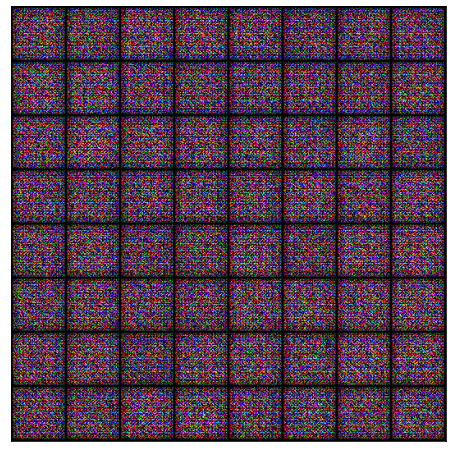

In [24]:
save_samples(0, fixed_latent)

In [25]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [26]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(dataloader):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [27]:
lr = 0.0002
epochs = 15

In [28]:
history = fit(epochs, lr)

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [1/15], loss_g: 4.0102, loss_d: 0.1853, real_score: 0.9229, fake_score: 0.0925
Saving generated-images-0001.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [2/15], loss_g: 3.0201, loss_d: 0.2853, real_score: 0.8127, fake_score: 0.0607
Saving generated-images-0002.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [3/15], loss_g: 1.6936, loss_d: 0.3467, real_score: 0.8540, fake_score: 0.1586
Saving generated-images-0003.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [4/15], loss_g: 7.5466, loss_d: 0.9646, real_score: 0.9777, fake_score: 0.5720
Saving generated-images-0004.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [5/15], loss_g: 2.4993, loss_d: 2.4414, real_score: 0.1146, fake_score: 0.0081
Saving generated-images-0005.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [6/15], loss_g: 3.7341, loss_d: 0.0487, real_score: 0.9867, fake_score: 0.0343
Saving generated-images-0006.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [7/15], loss_g: 4.2312, loss_d: 0.0703, real_score: 0.9531, fake_score: 0.0209
Saving generated-images-0007.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [8/15], loss_g: 2.3916, loss_d: 0.6840, real_score: 0.6325, fake_score: 0.1476
Saving generated-images-0008.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [9/15], loss_g: 4.2124, loss_d: 0.0313, real_score: 0.9940, fake_score: 0.0245
Saving generated-images-0009.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [10/15], loss_g: 4.0965, loss_d: 0.0632, real_score: 0.9623, fake_score: 0.0231
Saving generated-images-0010.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [11/15], loss_g: 4.2975, loss_d: 0.0575, real_score: 0.9760, fake_score: 0.0320
Saving generated-images-0011.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [12/15], loss_g: 4.0722, loss_d: 0.1426, real_score: 0.9599, fake_score: 0.0917
Saving generated-images-0012.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [13/15], loss_g: 7.2723, loss_d: 0.0099, real_score: 0.9909, fake_score: 0.0005
Saving generated-images-0013.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [14/15], loss_g: 3.5268, loss_d: 0.2630, real_score: 0.8326, fake_score: 0.0508
Saving generated-images-0014.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [15/15], loss_g: 3.4941, loss_d: 0.4406, real_score: 0.8600, fake_score: 0.2201
Saving generated-images-0015.png


In [29]:
losses_g, losses_d, real_scores, fake_scores = history

In [30]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G_cifar.pth')
torch.save(discriminator.state_dict(), 'D_cifar.pth')

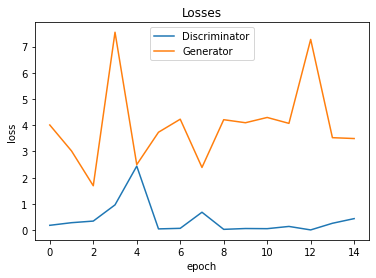

In [31]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');
plt.savefig("losses_generated3_dcgan.png")

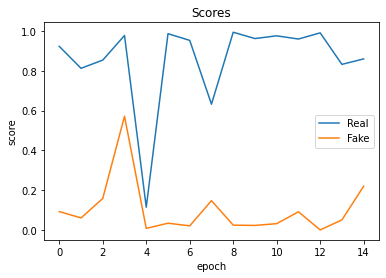

In [32]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');
plt.savefig("scores_generated3_dcgan.png")